In [20]:
#########################
# Example for using fermionic operators
# in the VMC framework
#########################

# VMC
import jVMC
import jVMC.nets as nets
import jVMC.operator as op
from jVMC.operator import number, creation, annihilation
import jVMC.sampler
from jVMC.util import ground_state_search, measure
from jVMC.vqs import NQS
from jVMC.stats import SampledObs
from jVMC import global_defs

# python stuff
import functools

# jax
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import flax.linen as nn

import jax.random as random

# numpy
import numpy as np

# plotting
import matplotlib.pyplot as plt

#########################
# check against openfermion
#########################

import openfermion as of
from openfermion.ops import FermionOperator as fop
from openfermion.linalg import get_sparse_operator

In [32]:
##########################
# custon tarbget wave function
# specific to openfermion compatibility
class Target(nn.Module):
  """Target wave function, returns a vector with the same dimension as the Hilbert space

    Initialization arguments:
        * ``L``: System size
        * ``d``: local Hilbert space dimension
        * ``delta``: small number to avoid log(0)

    """
  L: int
  d: float = 2.00
  delta: float = 1e-15

  @nn.compact
  def __call__(self, s):
    kernel = self.param('kernel',
                        nn.initializers.constant(1),
                        (int(self.d**self.L)))
    # return amplitude for state s
    idx = ((self.d**jnp.arange(self.L)).dot(s[::-1])).astype(int) # NOTE that the state is reversed to account for different bit conventions used in openfermion
    return jnp.log(abs(kernel[idx]+self.delta)) + 1.j*jnp.angle(kernel[idx]) 

## Fermionic operators

Fermionic operators have to satisfy the following condition
$$
\lbrace \hat{c}^\dagger_i, \hat{c}_j\rbrace  = \delta_{ij} \; ,
$$
where $i,j$ are so-called *flavours*.As is done in 'openfermoin' we do not allow for a spin quantum number. In other words, all our fermionic operators can only carry a single flavour. For higher flavour indeces one has combine several distinct fermionis.

The key to realizing fermions is the Jordan-Wigner factor. Every fermionic state is constructed using a filling order, then we have to count how many craetion operatros a given operator has to commute thorugh to arrive at his filling order position.
We can achieve this as follows.
$$
\hat{c}^\dagger\vert 1, 0 \rangle = (-1)^\Omega \vert 1,1\rangle
$$
with 
$$
\Omega = \sum^{j-1}_{i=0} s_i \; .
$$

In [33]:
#########################
# jVMC hamiltonian
#########################
t = - 1.0 # hopping
mu = -2.0 # chemical potential
V = 4.0 # interaction
L = 4   # number of sites
flavour = 2 # number of flavours
spinL = flavour*L # number of spins time

# initalize the Hamitonian
hamiltonian = op.BranchFreeOperator()
# impurity definitions
site1UP = 0
site1DO = spinL-1#//flavour
# loop over the 1d lattice
for i in range(0,spinL//flavour):
    # interaction
    hamiltonian.add(op.scal_opstr( V, ( number(site1UP + i) , number(site1DO - i) ) ) )
    # chemical potential
    hamiltonian.add(op.scal_opstr(mu , ( number(site1UP + i) ,) ) )
    hamiltonian.add(op.scal_opstr(mu , ( number(site1DO - i) ,) ) )
    if i == spinL//flavour-1:
        continue
    # up chain hopping
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1UP + i) ,creation(site1UP + i + 1)  ) ) )
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1UP + i + 1) ,creation(site1UP + i)  ) ) )
    # down chain hopping
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1DO - i) ,creation(site1DO - i - 1)  ) ) )
    hamiltonian.add(op.scal_opstr( t, ( annihilation(site1DO - i - 1) ,creation(site1DO - i)  ) ) )

In [34]:
#########################
# openfermion
#########################

H = 0.0*fop()
# loop over the 1d lattice
for i in range(0,spinL//flavour):
    H += fop(((site1UP + i,1),(site1UP + i,0),(site1DO - i,1),(site1DO - i,0)),V) 
    H += fop(((site1UP + i,1),(site1UP + i,0)),mu) + fop(((site1DO - i,1),(site1DO - i,0)),mu)
    if i == spinL//flavour-1:
        continue
    # up chain
    H += (fop(((site1UP + i,1),(site1UP + i + 1,0)),t) + fop(((site1UP + i + 1,1),(site1UP + i,0)),t))
    # down chain
    H += (fop(((site1DO - i,1),(site1DO - i - 1,0)),t) + fop(((site1DO - i - 1,1),(site1DO - i,0)),t))

In [35]:
#########################
# diagonalize the Openfermion Hamiltonain
#########################

ham = get_sparse_operator(H)
a, b = np.linalg.eigh(ham.toarray())

chi_model = Target(L=L, d=2)
chi = NQS(chi_model)
chi(jnp.array(jnp.ones((1, 1, L))))
chi.set_parameters(b[:,0]+1e-14)
chiSampler = jVMC.sampler.ExactSampler(chi, (L,))

In [36]:
s, logPsi, p = chiSampler.sample()
sPrime, _ = hamiltonian.get_s_primes(s)
Oloc = hamiltonian.get_O_loc(s, chi, logPsi)
Omean = jVMC.mpi_wrapper.global_mean(Oloc,p)

print("Ground state energy: \njVMC: %.8f, Openfermion: %.8f"%(Omean.real,a[0]))

Ground state energy: 
jVMC: -4.50000000, Openfermion: -9.95314531


### Finding the ground state brute force

In [14]:
# Set up variational wave function
all_states = Target(L=L, d=2)
psi = NQS(all_states)
# initialize NQS
print("Net init: ",psi(jnp.array(jnp.ones((1, 1, L)))))
# Set up exact sampler
exactSampler = jVMC.sampler.ExactSampler(psi, L)

Net init:  [[0.00278445+0.0221402j]]


In [15]:
# Set up sampler
sampler = jVMC.sampler.ExactSampler(psi, L)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=1e-1)  # ODE integrator

n_steps = 2000
res = []
for n in range(n_steps):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0), tdvpEquation.ElocVar0])

res = np.array(res)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[4.8, 4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - a[0], '-', label=r"$L=" + str(L) + "$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')

0 -0.853270576712947 0.22837423553850827
1 -0.8655089572871848 0.22544024296717785
2 -0.8889744435356554 0.2184718357917557
3 -0.9132117696650591 0.21068295752730293
4 -0.9361625223016138 0.20280121110598637
5 -0.9579837783188471 0.19488733556767007
6 -0.9787450375865246 0.18699555288147596
7 -0.9984738305586389 0.17918271739599806
8 -1.0171879471688339 0.17150185076203045
9 -1.0349051934394318 0.16399966842493569
10 -1.0516466606132029 0.15671562561683294
11 -1.06743765971108 0.14968168330782178
12 -1.082307677121522 0.1429224850733325
13 -1.0962898901830265 0.13645579301966676
14 -1.1094204920453206 0.13029308940217388
15 -1.1217379543331036 0.12444027702458976
16 -1.1332822985017135 0.11889842692331634
17 -1.144094415923703 0.11366453320284592
18 -1.1542154586132696 0.10873224446793987
19 -1.1636863110897626 0.1040925497149155
20 -1.1725471464215407 0.09973440387446608
21 -1.1808370645675506 0.09564528438934014
22 -1.188593807955982 0.09181167523110084
23 -1.1958535473139398 0.08821

KeyboardInterrupt: 

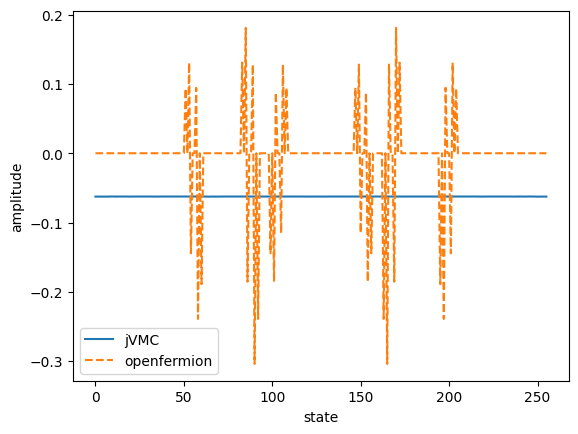

In [12]:
s, logPsi, _ = exactSampler.sample()
var_wf = np.real(np.exp(logPsi))[0]
# normalizing the wave function
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100)
plt.xlabel('state')
plt.ylabel('amplitude')
plt.plot(-var_wf,label='jVMC')
plt.plot(np.exp(chi(s)).real[0],'--',label='openfermion')
plt.legend()